In [53]:
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set any global values

In [54]:
torch.manual_seed(1)

# Load the training data

In [55]:
with open('training_data.pickle','rb') as f:
    training_data = pickle.load(f)

# Tokenization
- E format: fof(368,axiom,(a|~a)&(~a|~b)).fof(131,conjecture,(~b|~a)&(~a|a)).
- NN format: (a|~a)&(~a|~b)=>(~b|~a)&(~a|a)

- token list: ( ) a | ~ b => &

In [56]:
#don't need to use this
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq] #symbols assigned the tokenized index value
    return torch.tensor(idxs, dtype=torch.long) #return the sequence of token values

#don't need to use this
symbol_to_ix = {} #dict to store symbol to index values
for statement, classification in training_data:
    for symbol in statement:
        if symbol not in symbol_to_ix:  # symbol has not been assigned an index yet
            symbol_to_ix[symbol] = len(symbol)  # Assign each symbol with a unique index

In [57]:
import string

class_to_ix = {"Found": 0, "Unfound": 1}
all_letters = '()ab~&|>'

n_letters = len(all_letters)

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        if letter in all_letters:
            tensor[li][0][letterToIndex(letter)] = 1
    return tensor

category_lines = {}
all_categories = []
for category in class_to_ix:
    all_categories.append(category)

for sample in training_data:
    category = sample[1]
    if category not in category_lines:
        category_lines[category] = [sample[0]]
    elif category in category_lines:
        category_lines[category].append(sample[0])

n_categories = len(all_categories)

# Neural Network

In [58]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [62]:
input = lineToTensor(training_data[0][0])
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-0.6283, -0.7625]], grad_fn=<LogSoftmaxBackward0>)


In [60]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Found', 0)


In [63]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Unfound / line = (b|~a)>(a|~b)&(~b|b)
category = Unfound / line = (~b)&(a|~a)>(a|~a)&(~a)
category = Found / line = (~a)&(a|~a)>(~a)&(~b|b)
category = Unfound / line = (~a|~a)&(b|~b)>(b|~b)&(b|a)
category = Found / line = (~a|~a)>(a|~a)&(~a|~a)
category = Unfound / line = (b|b)&(~a|~a)>(~a|a)&(~b|~b)
category = Found / line = (~a|b)&(b|~b)>(b|~b)&(b|~a)
category = Found / line = (~a)&(~b|~a)>(~a|~a)&(b|~b)
category = Found / line = (~b)&(b|a)>(a|a)&(~b|~a)
category = Found / line = (~a)&(a|~b)>(~a|~a)&(~b|a)


In [64]:
criterion = nn.NLLLoss()

In [65]:
learning_rate = 0.01 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [66]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 0.9554 (~b|~b)&(~b|~a)>(~a)&(~b|a) / Found ✗ (Unfound)
10000 10% (0m 17s) 0.6660 (a)&(~b|a)>(b|a)&(~b|~b) / Unfound ✓
15000 15% (0m 25s) 0.2534 (b|~a)&(b|b)>(b|~a)&(~b|b) / Found ✓
20000 20% (0m 34s) 0.3786 (a|~b)&(a|b)>(a|a)&(~a) / Unfound ✓
25000 25% (0m 42s) 0.2037 (~b|b)&(~a|~b)>(b|~b) / Found ✓
30000 30% (0m 50s) 0.3070 (a)>(~a|a)&(~b|a) / Found ✓
35000 35% (0m 58s) 0.6856 (~b|~a)>(~b)&(~a) / Unfound ✓
40000 40% (1m 6s) 0.8790 (a|~a)&(~b)>(~b|~b)&(b|~a) / Found ✗ (Unfound)
45000 45% (1m 15s) 1.6444 (b)&(~a|~a)>(~b|~a)&(a|~b) / Found ✗ (Unfound)
50000 50% (1m 23s) 0.1455 (b|~a)&(~b|~b)>(~b|a)&(b|~b) / Found ✓
55000 55% (1m 31s) 0.3417 (b|b)&(~a)>(~a|~b)&(~b|~a) / Found ✓
60000 60% (1m 39s) 0.7419 (~a)&(a|~a)>(~b) / Found ✗ (Unfound)
65000 65% (1m 47s) 0.9341 (~b|a)&(~a)>(a)&(~b|~b) / Found ✗ (Unfound)
70000 70% (1m 55s) 0.9616 (~b|b)&(~a|~b)>(a|b)&(a|~a) / Found ✗ (Unfound)
75000 75% (2m 3s) 0.5749 (~a|b)&(~a)>(b|~a)&(b|b) / Unfound ✓
80000 80% (2m 11s) 0.2064 (~a|~

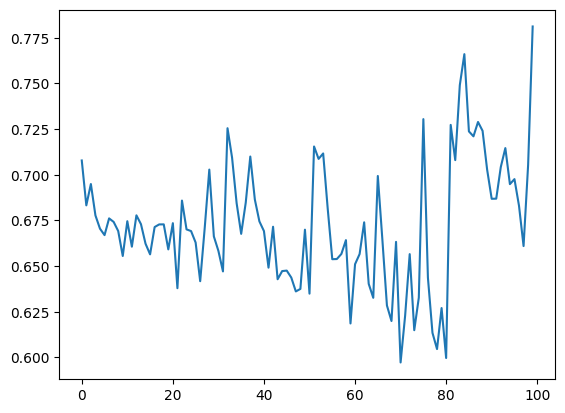

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_718/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_718/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


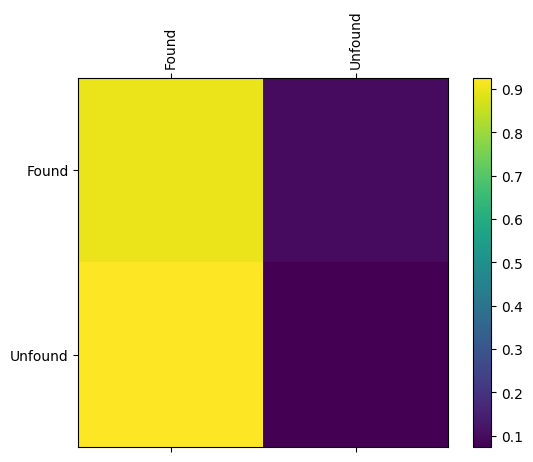

In [69]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [75]:
def predict(input_line, n_predictions=1):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('(a|a)>(a)')


> (a|a)>(a)
(-0.26) Unfound
